From 이수안 컴퓨터: http://suanlab.com/youtube/ml.html <br>
참조; https://needjarvis.tistory.com/621

# 나이브 베이즈 분류기(Naive Bayes Classification)

* 베이즈 정리를 적용한 확률적 분류 알고리즘
* 모든 특성들이 독립임을 가정 (naive 가정)
* 입력 특성에 따라 3개의 분류기 존재
  * 가우시안 나이브 베이즈 분류기
  * 베르누이 나이브 베이즈 분류기
  * 다항 나이브 베이즈 분류기

## 나이브 베이즈 분류기의 확률 모델

* 나이브 베이즈는 조건부 확률 모델
* *N*개의 특성을 나타내는 벡터 **x**를 입력 받아 k개의 가능한 확률적 결과를 출력

\begin{equation}
p(C_k | x_1,...,x_n)
\end{equation}

* 위의 식에 베이즈 정리를 적용하면 다음과 같음

\begin{equation}
p(C_k | \textbf{x}) = \frac{p(C_k)p(\textbf{x}|C_k)}{p(\textbf{x})}
\end{equation}

* 위의 식에서 분자만이 출력 값에 영향을 받기 때문에 분모 부분을 상수로 취급할 수 있음

\begin{equation}
\begin{split}
p(C_k | \textbf{x}) & \propto p(C_k)p(\textbf{x}|C_k) \\
& \propto p(C_k, x_1, ..., x_n)
\end{split}
\end{equation}

* 위의 식을 연쇄 법칙을 사용해 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & = p(C_k)p(x_1, ..., x_n | C_k) \\
& = p(C_k)p(x_1 | C_k)p(x_2, ..., x_n | C_k, x_1) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)p(x_3, ..., x_n | C_k, x_1, x_2) \\
& = p(C_k)p(x_1 | C_k)p(x_2 | C_k, x_1)...p(x_n | C_k, x_1, x_2, ..., x_{n-1})
\end{split}
\end{equation}

* 나이브 베이즈 분류기는 모든 특성이 독립이라고 가정하기 때문에 위의 식을 다음과 같이 쓸 수 있음

\begin{equation}
\begin{split}
p(C_k, x_1, ..., x_n) & \propto p(C_k)p(x_1|C_k)p(x_2|C_k)...p(x_n|C_k) \\
& \propto p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{split}
\end{equation}

* 위의 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과

\begin{equation}
\hat{y} = \underset{k}{\arg\max} \; p(C_k) \prod_{i=1}^{n} p(x_i|C_k)
\end{equation}

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import fetch_covtype, fetch_20newsgroups, load_iris, make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

In [2]:
seed = 2022
np.random.seed(seed)

In [3]:
prior = [0.45, 0.3, 0.15, 0.1]
likelihood = [[0.3, 0.3, 0.4], 
              [0.7, 0.2, 0.1], 
              [0.15, 0.5, 0.35],
              [0.6, 0.2, 0.2]]
idx = 0
for c, xs in zip(prior, likelihood):
    result = 1.
    
    for x in xs:
        result *= x
        
    result *= c
    
    idx += 1
    
    print(f'{idx}번째 클래스의 가능성: {result}')

1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


## 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ics.uci.edu/ml/datasets/Covertype 에서 데이터의 자세한 설명 확인 가능

In [4]:
# covtype = fetch_covtype() # covtype => cover type. forest cover type
# print(covtype.keys())
# print(covtype.DESCR())

위의 명령이 작동하지 않아서, 아래와 같이 따로 데이터를 받아서 거꾸로 데이터를 구성하여 진행 <br>
kaggle에서 자료 download: https://www.kaggle.com/uciml/forest-cover-type-dataset/version/1

In [5]:
covtype_df = pd.read_csv("./data/covtype.csv")

In [6]:
covtype_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
X = covtype_df.iloc[:, :-1].values
y = covtype_df.iloc[:, -1].values

In [8]:
X.shape

(581012, 54)

In [9]:
classes = list(np.unique(y))
classes

[1, 2, 3, 4, 5, 6, 7]

In [10]:
covtype_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [11]:
covtype_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [12]:
X # == contype.data

array([[2596,   51,    3, ...,    0,    0,    0],
       [2590,   56,    2, ...,    0,    0,    0],
       [2804,  139,    9, ...,    0,    0,    0],
       ...,
       [2386,  159,   17, ...,    0,    0,    0],
       [2384,  170,   15, ...,    0,    0,    0],
       [2383,  165,   13, ...,    0,    0,    0]], dtype=int64)

In [13]:
y # == contype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int64)

### 학습, 평가 데이터 분류

In [14]:
covtype_X = X
covtype_y = y

In [15]:
covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = \
     train_test_split(covtype_X, covtype_y, test_size=0.2, random_state=seed)

In [16]:
print('전체 데이터 크기: {}'.format(covtype_X.shape))
print('학습 데이터 크기: {}'.format(covtype_X_train.shape))
print('평가 데이터 크기: {}'.format(covtype_X_test.shape))

전체 데이터 크기: (581012, 54)
학습 데이터 크기: (464809, 54)
평가 데이터 크기: (116203, 54)


### 전처리

#### 전처리 전 데이터

In [17]:
covtype_train_df = pd.DataFrame(covtype_X_train, columns=covtype_df.columns[:-1])
covtype_test_df = pd.DataFrame(covtype_X_test, columns=covtype_df.columns[:-1])

In [18]:
covtype_test_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2957.354010,155.793000,14.107983,268.416900,46.169092,2350.421160,212.041711,223.214521,142.544754,1977.881544,...,0.043501,0.089602,0.077803,0.002840,0.003167,0.000181,0.000465,0.026153,0.023992,0.014862
std,280.031606,112.168842,7.511816,211.984495,57.967665,1556.899298,26.832226,19.857622,38.222096,1323.179908,...,0.203984,0.285612,0.267863,0.053215,0.056186,0.013442,0.021552,0.159589,0.153026,0.121001
min,1866.000000,0.000000,0.000000,0.000000,-163.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2806.000000,58.000000,9.000000,108.000000,7.000000,1107.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2994.000000,127.000000,13.000000,218.000000,29.000000,2001.000000,218.000000,226.000000,143.000000,1708.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3162.000000,261.000000,18.000000,384.000000,69.000000,3329.500000,231.000000,237.000000,168.000000,2544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3857.000000,360.000000,61.000000,1358.000000,598.000000,7117.000000,254.000000,254.000000,254.000000,7172.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 전처리 과정

In [19]:
scaler = StandardScaler()
covtype_X_train_scale = scaler.fit_transform(covtype_X_train)
covtype_X_test_scale = scaler.transform(covtype_X_test)

#### 전처리 후 데이터
* 평균은 0에 가깝게, 표준평차는 1에 가깝게 정규화

In [20]:
covtype_train_scale_df = pd.DataFrame(covtype_X_train_scale, columns=covtype_df.columns[:-1])
covtype_test_scale_df = pd.DataFrame(covtype_X_test_scale, columns=covtype_df.columns[:-1])

In [21]:
covtype_test_scale_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,-0.008980,0.001522,0.000715,-0.005944,-0.005348,0.000220,-0.004875,-0.006596,0.000538,-0.002274,...,-0.004088,-0.003442,0.000408,0.001600,-0.001920,-0.002075,-0.002630,-0.005022,0.001894,-0.002029
std,1.000217,1.002852,1.003940,0.996685,0.992994,0.998113,1.002916,1.005637,0.998288,0.999042,...,0.990906,0.995076,1.000648,1.015067,0.983169,0.925835,0.940904,0.985218,1.005915,0.991905
min,-3.907080,-1.391355,-1.884790,-1.267956,-3.588442,-1.506612,-7.930418,-11.310705,-3.722460,-1.495637,...,-0.215408,-0.315617,-0.290240,-0.052570,-0.057336,-0.014522,-0.022918,-0.166473,-0.155820,-0.123860
25%,-0.549586,-0.872802,-0.681957,-0.760174,-0.676320,-0.796925,-0.529716,-0.523883,-0.614406,-0.722485,...,-0.215408,-0.315617,-0.290240,-0.052570,-0.057336,-0.014522,-0.022918,-0.166473,-0.155820,-0.123860
50%,0.121912,-0.255903,-0.147365,-0.242988,-0.299457,-0.223790,0.217830,0.134467,0.012429,-0.206043,...,-0.215408,-0.315617,-0.290240,-0.052570,-0.057336,-0.014522,-0.022918,-0.166473,-0.155820,-0.123860
75%,0.721975,0.942131,0.520876,0.537492,0.385748,0.627898,0.703735,0.691533,0.665381,0.425163,...,-0.215408,-0.315617,-0.290240,-0.052570,-0.057336,-0.014522,-0.022918,-0.166473,-0.155820,-0.123860
max,3.204377,1.827247,6.267744,5.116936,9.447588,3.056026,1.563412,1.552453,2.911538,3.919448,...,4.642359,3.168400,3.445426,19.022317,17.441131,68.861811,43.634332,6.006984,6.417658,8.073650


## 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [22]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [23]:
print(newsgroup.data[:][3])

From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

--
Joe Green				Harris Corporation
jgreen@csd.harris.com			Computer Systems Division
"The only thing that really scares me is a person with no sense of humor."
						-- Jonathan Winters



In [24]:
newsgroup.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 학습, 평가 데이터 분류

In [25]:
newsgroup_train = fetch_20newsgroups(subset='train', random_state=seed)
newsgroup_test = fetch_20newsgroups(subset='test', random_state=seed)

In [26]:
X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### CountVectorizer
* 문서에 나온 단어의 수를 count하여 벡터 생성

In [27]:
count_vectorizer = CountVectorizer()

In [28]:
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [29]:
# 첫번째 element를 리스트로 만들어 단어 토큰화 점검
X_train_count_0 = count_vectorizer.fit(X_train[0:1])
X_train_count_all = count_vectorizer.fit(X_train)

In [30]:
# sort by value in dict
{k: v for k, v in sorted(X_train_count_0.vocabulary_.items(), key=lambda item: item[1])}
# 각 단어와 매칭되는 일련번호가 생성됨.

{'00': 0,
 '000': 1,
 '0000': 2,
 '00000': 3,
 '000000': 4,
 '00000000': 5,
 '0000000004': 6,
 '0000000005': 7,
 '00000000b': 8,
 '00000001': 9,
 '00000001b': 10,
 '0000000667': 11,
 '00000010': 12,
 '00000010b': 13,
 '00000011': 14,
 '00000011b': 15,
 '0000001200': 16,
 '00000074': 17,
 '00000093': 18,
 '000000e5': 19,
 '00000100': 20,
 '00000100b': 21,
 '00000101': 22,
 '00000101b': 23,
 '00000110': 24,
 '00000110b': 25,
 '00000111': 26,
 '00000111b': 27,
 '00000315': 28,
 '000005102000': 29,
 '00000510200001': 30,
 '000007': 31,
 '00000ee5': 32,
 '00001000': 33,
 '00001000b': 34,
 '00001001': 35,
 '00001001b': 36,
 '00001010': 37,
 '00001010b': 38,
 '00001011': 39,
 '00001011b': 40,
 '000010af': 41,
 '00001100': 42,
 '00001100b': 43,
 '00001101': 44,
 '00001101b': 45,
 '00001110': 46,
 '00001110b': 47,
 '00001111': 48,
 '00001111b': 49,
 '000021': 50,
 '000042': 51,
 '000062david42': 52,
 '000094': 53,
 '0000vec': 54,
 '0001': 55,
 '00010000': 56,
 '00010000b': 57,
 '00010001': 58,


데이터를 희소 행렬(sparse matrix) 형태로 표현

In [31]:
X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [32]:
X_train_count_0.vocabulary_

{'from': 56979,
 'mhollowa': 81727,
 'ic': 65506,
 'sunysb': 111838,
 'edu': 50527,
 'michael': 81794,
 'holloway': 63762,
 'subject': 111322,
 're': 99721,
 'science': 105252,
 'and': 28146,
 'methodology': 81376,
 'was': 123292,
 'homeopathy': 63828,
 'tradition': 116061,
 'nntp': 87620,
 'posting': 95162,
 'host': 64095,
 'engws5': 51755,
 'organization': 90379,
 'state': 110355,
 'university': 118983,
 'of': 89362,
 'new': 86864,
 'york': 128387,
 'at': 30044,
 'stony': 110825,
 'brook': 35153,
 'lines': 76032,
 '54': 15251,
 'in': 66608,
 'article': 29573,
 '1993apr16': 6512,
 '155919': 4887,
 '28040': 10175,
 'cs': 43740,
 'rochester': 102713,
 'fulk': 57234,
 'mark': 79503,
 'writes': 125271,
 'c5kv7p': 36703,
 'jm3': 70332,
 'unx': 119392,
 'sas': 104679,
 'com': 41105,
 'sasghm': 104685,
 'theseus': 114628,
 'gary': 58196,
 'merrill': 81228,
 '1993apr15': 6511,
 '200344': 8301,
 '28013': 10171,
 'what': 123984,
 'is': 68532,
 'wrong': 125288,
 'with': 124616,
 'the': 114455,
 

In [33]:
type(X_train_count_all)
# find vocabulary corresponding to the allocated number
reverse_X_train_count = { v : k for k, v in X_train_count_all.vocabulary_.items()}

In [34]:
reverse_X_train_count[56979]
# 56979로 할당된 문자는 'from'

'from'

In [35]:
X_train_count_all.transform(['This is the second document.']).toarray()
# 각 단어가 할단된 번호 위치에 발생빈도를 표시. 리스트 단위로 진행하여 sparse amtrix 형성

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [36]:
for v in X_train_count[0]:
    print(v)
# (0, 56979)    2  => 0 번째 문장에서 56979로 변환된 단어가 2개 나옴.

  (0, 56979)	2
  (0, 81727)	1
  (0, 65506)	2
  (0, 111838)	2
  (0, 50527)	6
  (0, 81794)	1
  (0, 63762)	1
  (0, 111322)	1
  (0, 99721)	1
  (0, 105252)	3
  (0, 28146)	15
  (0, 81376)	1
  (0, 123292)	5
  (0, 63828)	1
  (0, 116061)	1
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 51755)	1
  (0, 90379)	1
  (0, 110355)	1
  (0, 118983)	1
  (0, 89362)	23
  (0, 86864)	1
  (0, 128387)	1
  :	:
  (0, 106296)	1
  (0, 56500)	1
  (0, 119740)	1
  (0, 50181)	1
  (0, 47366)	1
  (0, 56899)	1
  (0, 27436)	1
  (0, 115133)	1
  (0, 26747)	1
  (0, 101358)	1
  (0, 99755)	1
  (0, 27585)	1
  (0, 81948)	1
  (0, 101000)	1
  (0, 99822)	2
  (0, 67798)	2
  (0, 66474)	1
  (0, 55223)	1
  (0, 83417)	1
  (0, 58631)	1
  (0, 64186)	1
  (0, 99872)	1
  (0, 117038)	1
  (0, 118750)	1
  (0, 82034)	1


CountVectorizer는 모든 작업을 메모리 상에서 수행하므로 처리할 문서의 크기가 커지면 속도가 느려지거나 실행이 불가능해진다. 이 때 HashingVectorizer를 사용하면 해시 함수를 사용하여 단어에 대한 인덱스 번호를 생성하기 때문에 메모리 및 실행 시간을 줄일 수 있다.

#### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [37]:
hash_vectorizer = HashingVectorizer(n_features=1000)

In [38]:
X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [39]:
X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [40]:
print(X_train_hash[0])
# (0, 1)     -0.017144816662454657  => 1번에 해당되는 단어가 -0.017144816662454657 로 지정됨

  (0, 1)	-0.017144816662454657
  (0, 4)	0.017144816662454657
  (0, 5)	-0.051434449987363975
  (0, 10)	0.017144816662454657
  (0, 13)	-0.017144816662454657
  (0, 20)	-0.017144816662454657
  (0, 22)	0.017144816662454657
  (0, 23)	-0.017144816662454657
  (0, 29)	0.051434449987363975
  (0, 30)	0.017144816662454657
  (0, 32)	0.0
  (0, 34)	-0.017144816662454657
  (0, 35)	-0.017144816662454657
  (0, 38)	0.051434449987363975
  (0, 39)	-0.017144816662454657
  (0, 40)	-0.08572408331227328
  (0, 47)	0.017144816662454657
  (0, 56)	0.034289633324909315
  (0, 60)	-0.017144816662454657
  (0, 61)	-0.017144816662454657
  (0, 62)	0.017144816662454657
  (0, 64)	-0.017144816662454657
  (0, 66)	-0.017144816662454657
  (0, 69)	-0.017144816662454657
  (0, 70)	0.034289633324909315
  :	:
  (0, 933)	-0.017144816662454657
  (0, 935)	0.017144816662454657
  (0, 937)	-0.06857926664981863
  (0, 939)	-0.034289633324909315
  (0, 940)	-0.017144816662454657
  (0, 942)	-0.017144816662454657
  (0, 945)	-0.0342896333249093

#### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [41]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [42]:
X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [43]:
for v in X_train_tfidf[0]:
    print(v)

  (0, 82034)	0.02906545716508147
  (0, 118750)	0.052057796632427544
  (0, 117038)	0.03477688699499205
  (0, 99872)	0.048967744908037666
  (0, 64186)	0.016096202546335266
  (0, 58631)	0.05097971092791811
  (0, 83417)	0.048722326267761205
  (0, 55223)	0.04080184883099661
  (0, 66474)	0.04647326250518383
  (0, 67798)	0.059792913274850645
  (0, 99822)	0.04137484330967798
  (0, 101000)	0.05616860821913193
  (0, 81948)	0.03427033345369121
  (0, 27585)	0.04189289786375994
  (0, 99755)	0.02291131215153194
  (0, 101358)	0.03188666925379369
  (0, 26747)	0.028016451392658633
  (0, 115133)	0.017792119267022198
  (0, 27436)	0.013544037372383787
  (0, 56899)	0.05974117632649521
  (0, 47366)	0.049486034840061595
  (0, 50181)	0.03791452763719546
  (0, 119740)	0.020661195198140053
  (0, 56500)	0.04564952168797066
  (0, 106296)	0.03933512350323768
  :	:
  (0, 128387)	0.030896006107493282
  (0, 86864)	0.018421736387380972
  (0, 89362)	0.18252364213369413
  (0, 118983)	0.013539308162066799
  (0, 110355)	0

## 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [44]:
model = GaussianNB()
model.fit(covtype_X_train_scale, covtype_y_train)

GaussianNB()

In [48]:
predict = model.predict(covtype_X_train_scale)
acc = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Accuracy : 0.08795440707903676
F1_score : [0.04002333 0.01769448 0.3347189  0.13910463 0.04306652 0.07190181
 0.2347201 ]


In [49]:
predict = model.predict(covtype_X_test_scale)
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.08881870519693984
Test F1_score : [0.04220064 0.01897925 0.33604816 0.13535705 0.04510227 0.07275915
 0.23093803]


In [59]:
def make_meshgrid(x, y, h=0.2):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    
    return out

In [75]:
X, y = make_blobs(n_samples=1000)

<span style='color:red'>make_blobs 함수</span>는 가우시안 정규분포를 이용해 가상 데이터를 생성.  <br>
make_blobs는 일반적으로 클러스링 가상데이터를 생성하는데 사용.<br> 

Input Parameter <br>
n_samples : 표본 데이터의 수, 디폴트 100 <br>
n_features : 독립 변수의 수, 디폴트 20 <br>
centers : 생성할 클러스터의 수 혹은 중심, [n_centers, n_features] 크기의 배열. 디폴트 3 <br>
cluster_std: 클러스터의 표준 편차, 디폴트 1.0 <br>
center_box: 생성할 클러스터의 바운딩 박스(bounding box), 디폴트 (-10.0, 10.0)) <br>
shuffle: TRUE하면 숫자를 랜덤으로 섞어주는 역할을 한다. <br>
 
Return Parameter: <br>
X : [n_samples, n_features] 크기의 배열: 독립 변수 <br>
y : [n_samples] 크기의 배열: 종속 변수 <br>

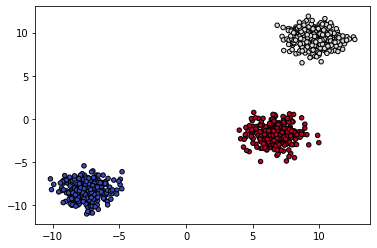

In [76]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [77]:
model = GaussianNB()
model.fit(X, y)

GaussianNB()

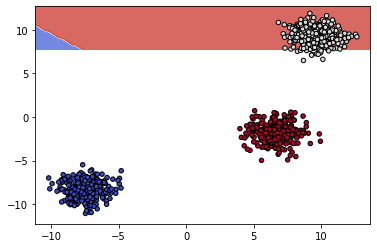

In [78]:
xx, yy = make_meshgrid(X[:,0], X[:1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [79]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB()

In [81]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Train Accuracy : 0.7821283365741559
Train F1_score : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [84]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [85]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.6307753584705258
Test F1_score : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 학습 및 평가 (Hash)

In [88]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

BernoulliNB()

In [89]:
predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Train Accuracy : 0.5951917977726711
Train F1_score : [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [90]:
predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.4430430164630908
Test F1_score : [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


### 학습 및 평가 (Tf-idf)

In [91]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [92]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Train Accuracy : 0.7821283365741559
Train F1_score : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [93]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.6307753584705258
Test F1_score : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


### 시각화

In [94]:
X, y = make_blobs(n_samples=1000)

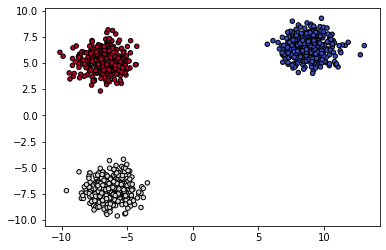

In [97]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [98]:
model = BernoulliNB()
model.fit(X, y)

BernoulliNB()

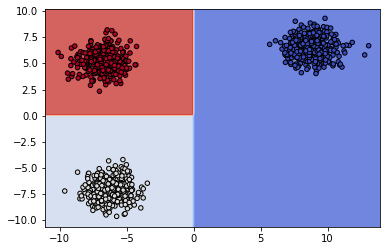

In [100]:
xx, yy = make_meshgrid(X[:,0], X[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

### 학습 및 평가 (Count)

In [101]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [102]:
predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Train Accuracy : 0.9245182959165635
Train F1_score : [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [103]:
predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.7728359001593202
Test F1_score : [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


### 학습 및 평가 (Tf-idf)

In [104]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [105]:
predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy : {}'.format(acc))
print('Train F1_score : {}'.format(f1))

Train Accuracy : 0.9326498143892522
Train F1_score : [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [106]:
predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1_score : {}'.format(f1))

Test Accuracy : 0.7738980350504514
Test F1_score : [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


### 시각화

In [132]:
X, y = make_blobs(n_samples=1000)

In [133]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

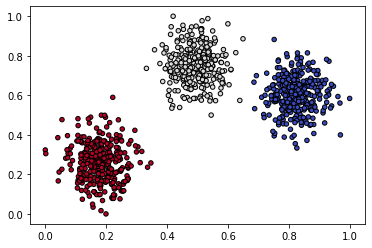

In [134]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [135]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

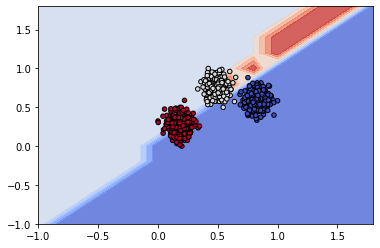

In [136]:
xx, yy = make_meshgrid(X[:,0], X[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')